[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Failed with encoding: utf-8
Successfully loaded with encoding: latin-1
Columns: ['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']
Dataset shape: (16363, 2)
sentiment
positive    8582
negative    7781
Name: count, dtype: int64
Example cleaned text:
sooo sad miss san diego

Top 20 Positive Words:
day        0.035661
good       0.031835
happy      0.030414
love       0.028542
mothers    0.025357
thanks     0.024009
great      0.017161
hope       0.014493
nice       0.013317
fun        0.012896
thank      0.012813
like       0.012619
morning    0.012203
lol        0.011672
night      0.011314
awesome    0.011263
today      0.010118
get        0.010062
got        0.009849
wish       0.009829
dtype: float64

Top 20 Negative Words:
miss      0.020283
sad       0.016990
dont      0.016151
cant      0.015886
sorry     0.015742
like      0.014490
work      0.014280
get       0.013274
bad       0.0

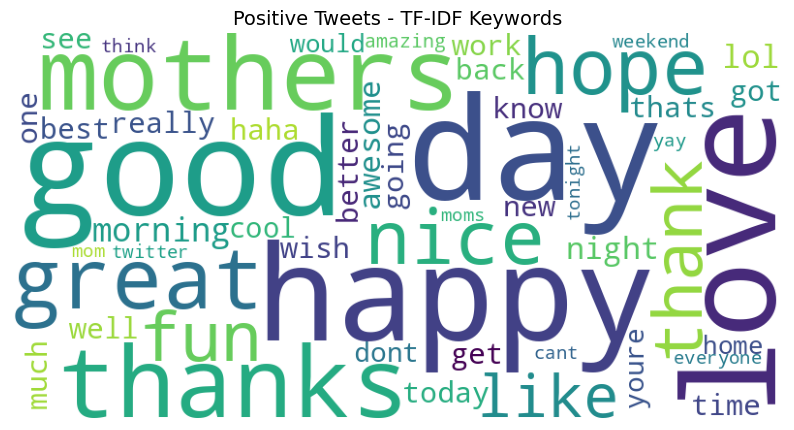

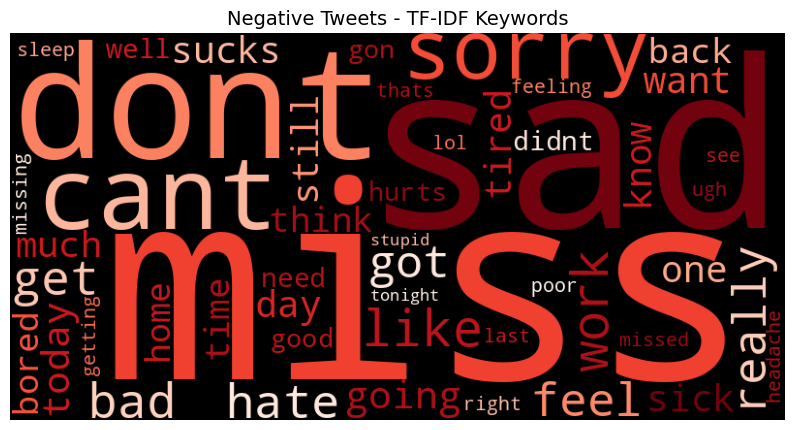

In [2]:
# --- Step 0: Install & Import dependencies ---
!pip install scikit-learn wordcloud

import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# --- Step 1: Download NLTK resources ---
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# --- Step 2: Safe CSV loading function ---
def safe_read_csv(path):
    """
    Try multiple encodings to safely read CSV files.
    """
    for enc in ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Successfully loaded with encoding: {enc}")
            return df
        except UnicodeDecodeError:
            print(f"Failed with encoding: {enc}")
    raise ValueError("All decoding attempts failed. Please check the file format.")

# Load your dataset
df = safe_read_csv("/content/train.csv")

# --- Step 3: Keep only relevant columns and filter sentiments ---
print("Columns:", df.columns.tolist())

df = df[['text', 'sentiment']].dropna()
df = df[df['sentiment'].isin(['positive', 'negative'])].copy()

print("Dataset shape:", df.shape)
print(df['sentiment'].value_counts())

# --- Step 4: Text cleaning ---
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Lowercase, remove URLs, mentions, hashtags, non-alphabetic characters,
    stopwords, and short words.
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

print("Example cleaned text:")
print(df['clean_text'].iloc[0])

# --- Step 5: TF-IDF vectorization ---
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
feature_names = vectorizer.get_feature_names_out()

# --- Step 6: Compute average TF-IDF per sentiment ---
pos_idx = df['sentiment'] == 'positive'
neg_idx = df['sentiment'] == 'negative'

X_pos = X[pos_idx.values, :]
X_neg = X[neg_idx.values, :]

# Compute mean TF-IDF for each word
pos_mean = np.asarray(X_pos.mean(axis=0)).ravel()
neg_mean = np.asarray(X_neg.mean(axis=0)).ravel()

# Convert to Pandas Series
pos_scores = pd.Series(pos_mean, index=feature_names).sort_values(ascending=False)
neg_scores = pd.Series(neg_mean, index=feature_names).sort_values(ascending=False)

# --- Step 7: Display top words ---
print("\nTop 20 Positive Words:")
print(pos_scores.head(20))

print("\nTop 20 Negative Words:")
print(neg_scores.head(20))

# --- Step 8: Visualization with WordCloud ---
plt.figure(figsize=(10,6))
WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_scores.head(50).to_dict())
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_scores.head(50).to_dict()))
plt.axis('off')
plt.title("Positive Tweets - TF-IDF Keywords", fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(neg_scores.head(50).to_dict())
plt.imshow(WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(neg_scores.head(50).to_dict()))
plt.axis('off')
plt.title("Negative Tweets - TF-IDF Keywords", fontsize=14)
plt.show()
